<a href="https://colab.research.google.com/github/zyadalghamdi202/Colab/blob/main/Copy_of_Wetaan_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
!pip install streamlit streamlit-drawable-canvas pyngrok --quiet

import joblib
from pyngrok import ngrok
import os
import threading

import streamlit as st
from PIL import Image
from streamlit_drawable_canvas import st_canvas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


2025-07-04 20:35:53.560 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## **Data**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

## **Sample Image**

torch.Size([64, 1, 28, 28])
torch.Size([64])


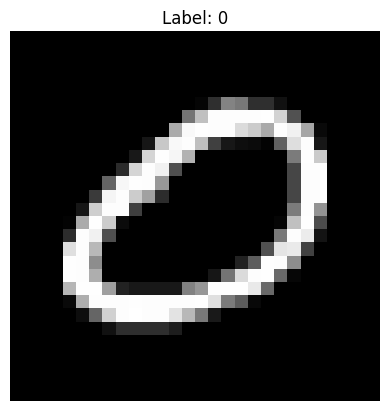

In [ ]:
for images, labels in trainloader:
  print(images.shape)
  print(labels.shape)
  break


plt.imshow(images[0].squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3) # (3, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2) # (2, 2) stride = 2
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1352, 10) # 8 * 13 * 13

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = CNN()

In [ ]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=4

for epoch in range(epochs):
    for imgs, labels in trainloader:
        preds = model(imgs)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



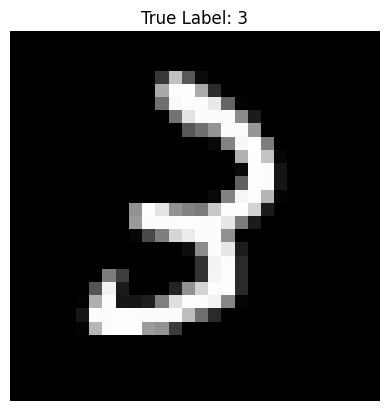

Predicted Label: 3


In [ ]:

dataiter = iter(testloader)
images, labels = next(dataiter)

img = images[63]
true_label = labels[63].item()

plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"True Label: {true_label}")
plt.show()

model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0))
    predicted_label = torch.argmax(output, dim=1).item()

print(f"Predicted Label: {predicted_label}")


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for imgs_batch, labels_batch in testloader:
        outputs = model(imgs_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")



Accuracy on test set: 97.36%


## **Bonus Task:**
Link the model to an interactive streamlit app :)

In [ ]:
%%writefile model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3) # (3, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2) # (2, 2) stride = 2
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1352, 10) # 8 * 13 * 13

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=2

for epoch in range(epochs):
    for imgs, labels in trainloader:
        preds = model(imgs)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def import_model():
  return model



Overwriting model.py


In [ ]:
%%writefile app.py

import torch
import numpy as np
import torchvision.transforms as transforms


import streamlit as st
from PIL import Image
from streamlit_drawable_canvas import st_canvas
from model import import_model

model = import_model()

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

st.title("🖌️ Draw a Digit")

st.markdown("ارسم رقمًا بخط يدك في المربع بالأسفل ثم انقر خارج المربع لتبدأ التنبؤ.")

# واجهة الرسم
canvas_result = st_canvas(
    fill_color="white",
    stroke_width=10,
    stroke_color="white",
    background_color="black",
    width=200,
    height=200,
    drawing_mode="freedraw",
    key="canvas"
)

if canvas_result.image_data is not None:
    image = Image.fromarray((canvas_result.image_data[:, :, 0]).astype(np.uint8))
    resized_image = image.resize((28, 28))

    st.image(resized_image, caption="Resized Input", width=150)

    input_tensor = preprocess_image(resized_image)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    st.success(f"Predicted Digit: {pred}")

Overwriting app.py


In [ ]:
!ngrok config add-authtoken 2zK6TG51lreSfp7dTwEBGmJz8Mh_5qw8yxDoTLULpfYearqyc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!which streamlit

/usr/local/bin/streamlit


In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8501, "http")
print(f"Streamlit URL: {public_url}")

!streamlit run app.py &


Streamlit URL: NgrokTunnel: "https://037a-35-229-202-95.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.202.95:8501

2025-07-04 21:27:19.686 MediaFileHandler: Missing file 8f45de48a88e0c40a798d542407e023766dc52e5f3b4f88f403d874d.jpg
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 348, in run
    if asyncio.get_running_loop().is_running():
       ^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: no running event loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/memory_media_file_storage.py", line 140, in get_file
    return self._files_by_id[file_id]
           ~~~~~~~~~~~~~~~~~^^^^^^^^^
KeyError: '8f45de48a88e0c40a798d542407e023766dc52e5f3b4f88f403